In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix,\
precision_score,recall_score,roc_curve

from tqdm.auto import tqdm
import scipy.sparse    # 稀疏矩阵的处理
import pickle
import gc

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample_submit = pd.read_csv('input/sample_submit.csv')

# **EDA**
目的：
- 1.EDA价值主要在于熟悉了解整个数据集的基本情况（缺失值，异常值），对数据集进行验证是否可以进行接下来的机器学习或者深度学习建模.
- 2.了解变量间的相互关系、变量与预测值之间的存在关系。
- 3.为特征工程做准备

内容：
- 数据总体了解
    - 读取数据集并了解数据集大小，原始特征维度；
    - 通过info熟悉数据类型；
    - 粗略查看数据集中各特征基本统计量 discribe
- 缺失值和唯一值
    - 查看数据缺失值情况
    - 查看唯一值特征情况
- 深入数据-查看数据类型
    - 类别型数据
    - 数值型数据
        - 离散数值型数据
        - 连续数值型数据
- 数据间相关关系
    - 特征和特征之间关系
    - 特征和目标变量之间关系
- 用pandas_profiling生成数据报告

- 异常值处理

## 1. 数据总体了解

In [3]:
# 数据集维度
train.shape,test.shape

((150000, 53), (30000, 52))

In [4]:
# 数据类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    150000 non-null  int64  
 1   main_account_loan_no           150000 non-null  int64  
 2   main_account_active_loan_no    150000 non-null  int64  
 3   main_account_overdue_no        150000 non-null  int64  
 4   main_account_outstanding_loan  150000 non-null  int64  
 5   main_account_sanction_loan     150000 non-null  int64  
 6   main_account_disbursed_loan    150000 non-null  int64  
 7   sub_account_loan_no            150000 non-null  int64  
 8   sub_account_active_loan_no     150000 non-null  int64  
 9   sub_account_overdue_no         150000 non-null  int64  
 10  sub_account_outstanding_loan   150000 non-null  int64  
 11  sub_account_sanction_loan      150000 non-null  int64  
 12  sub_account_disbursed_loan    

|特征字段|字段描述|
customer_id客户标识符
main_account_loan_no	主账户申请贷款数量
main_account_active_loan_no	主账户申请的有效贷款数量
main_account_overdue_no	主账号逾期数量
main_account_outstanding_loan	主账户未偿还的贷款余额
main_account_sanction_loan	主账户所有贷款被批准的贷款金额
main_account_disbursed_loan	主账户所有贷款已发放的贷款金额
sub_account_loan_no	二级账户申请贷款数量
sub_account_active_loan_no	二级账户申请的有效贷款数量
sub_account_overdue_no	二级账户逾期数量
sub_account_outstanding_loan	二级账户未偿还的贷款金额
sub_account_sanction_loan	二级账户所有贷款被批准的贷款金额
sub_account_disbursed_loan	二级账户所有贷款已发放的贷款金额
disbursed_amount	已发放贷款金额
asset_cost	资产成本
branch_id	发放贷款的分行
supplier_id	发放贷款的车辆经销商
manufacturer_id	汽车制造商
year_of_birth	客户出生日期
disbursed_date	贷款日期
area_id	付款区域
employee_code_id	记录付款的对接员工
mobileno_flag	是否填写手机号
idcard_flag	是否填写身份证
Driving_flag	是否出具驾驶证
passport_flag	是否填写护照
credit_score	信用评分
main_account_monthly_payment	主账户月供金额
sub_account_monthly_payment	二级账户的月供金额
last_six_month_new_loan_no	过去六个月客户的新贷款申请数量
last_six_month_defaulted_no	过去六个月客户的违约数量
average_age	平均贷款期限
credit_history	信用记录
enquirie_no	客户查询贷款次数
loan_to_asset_ratio	贷款与资产比例
total_account_loan_no	所有账户申请贷款数量
main_account_inactive_loan_no	主账户申请的无效贷款数量
sub_account_inactive_loan_no	二级账户申请的无效贷款数量
total_inactive_loan_no	所有账户申请的无效贷款数量
total_overdue_no	所有账户的逾期次数
total_outstanding_loan	所有账户的未结余额的总额
total_sanction_loan	来自所有账户的所有贷款被批准的贷款金额
total_disbursed_loan	为所有账户的所有贷款支付的贷款金额
total_monthly_payment	所有账户的月供金额
outstanding_disburse_ratio	已发放贷款总额/未偿还贷款总额（两者比例）
main_account_tenure	主账户还款期数
sub_account_tenure	二级账户还款期数
disburse_to_sactioned_ratio	已发放贷款/批准贷款（两者比例）
active_to_inactive_act_ratio	有效贷款次数/无效贷款次数（两者比例）
Credit_level	信用评分
employment_type	工作类型
age	年龄
loan_default	1表示客户逾期，0表示客户未逾期

In [5]:
train['loan_default'].value_counts()

0    123455
1     26545
Name: loan_default, dtype: int64

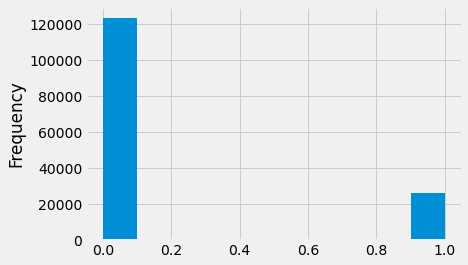

In [6]:
train['loan_default'].plot.hist();

In [7]:
len(train.loc[train['loan_default']==1,'loan_default'])\
/len(train['loan_default'])

0.17696666666666666

In [8]:
id = 'customer_id'
target_name = 'loan_default'

In [9]:
train.head(3).append(train.tail(3))

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.50,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.33,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.00,1991,2019,13,1,28,0
149997,1125,21,4,0,60522,119000,119000,0,0,0,...,3,0,1.00,1.22,1981,2019,7,0,38,0
149998,4752,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1988,2019,-1,0,31,0
149999,31397,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1988,2019,-1,1,31,0


In [10]:
# 总体粗略的查看数据集各个特征的一些基本统计量
train.describe()

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,1.500000e+05,1.500000e+05,150000.000000,150000.000000,150000.000000,...,1.500000e+05,1.500000e+05,1.500000e+05,150000.000000,150000.000000,150000.0,150000.000000,150000.000000,150000.000000,150000.000000
mean,99944.368847,2.447133,1.045500,0.153427,1.670825e+05,2.225586e+05,2.221730e+05,0.060133,0.027967,0.007293,...,5.169842e+04,2.773138e+03,6.506428e+02,1.438740,1984.867900,2019.0,3.132360,0.487507,34.132100,0.176967
std,57629.110557,5.197172,1.952708,0.542496,9.808619e+05,2.840313e+06,2.844075e+06,0.652912,0.325185,0.111236,...,2.614563e+06,1.043622e+05,1.312314e+05,0.789844,9.813379,0.0,5.268384,0.561527,9.813379,0.381642
min,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1950.000000,2019.0,-1.000000,0.000000,18.000000,0.000000
25%,50069.750000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1978.000000,2019.0,-1.000000,0.000000,26.000000,0.000000
50%,99887.500000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1987.000000,2019.0,-1.000000,0.000000,32.000000,0.000000
75%,149916.500000,3.000000,1.000000,0.000000,3.545900e+04,6.360000e+04,6.150850e+04,0.000000,0.000000,0.000000,...,2.500000e+01,0.000000e+00,1.000000e+00,1.670000,1993.000000,2019.0,8.000000,1.000000,41.000000,0.000000
max,199716.000000,354.000000,144.000000,23.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,7.000000,...,1.000000e+09,1.980000e+07,5.000000e+07,18.000000,2001.000000,2019.0,13.000000,2.000000,69.000000,1.000000


## 2. 缺失值情况，唯一值情况
- 纵向了解哪些列存在 “nan”, 并可以把nan的个数打印，主要的目的在于查看某一列nan存在的个数是否真的很大，如果nan存在的过多，说明这一列对label的影响几乎不起作用了，可以考虑删掉。如果缺失值很小一般可以选择填充。
- 另外可以横向比较，如果在数据集中，某些样本数据的大部分列都是缺失的且样本足够的情况下可以考虑删除。

- Tips: 比赛大杀器lgb模型可以自动处理缺失值

In [11]:
# train.isnull().any()查看每列是否有缺失值
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 0 columns in train dataset with missing values.


In [12]:
# 进一步查看缺失特征中缺失率大于50%的特征
have_null_fea_dict = (train.isnull().sum()/len(train)).to_dict()
fea_null_moreThanHalf = {}
for key,value in have_null_fea_dict.items():
    if value > 0.5:
        fea_null_moreThanHalf[key] = value
fea_null_moreThanHalf

{}

In [13]:
# 具体的查看缺失特征及缺失率
# nan可视化
missing = train.isnull().sum()/len(train)
missing
# missing = missing[missing > 0]
# missing.sort_values(inplace=True)
# missing.plot.bar()

customer_id                      0.0
main_account_loan_no             0.0
main_account_active_loan_no      0.0
main_account_overdue_no          0.0
main_account_outstanding_loan    0.0
main_account_sanction_loan       0.0
main_account_disbursed_loan      0.0
sub_account_loan_no              0.0
sub_account_active_loan_no       0.0
sub_account_overdue_no           0.0
sub_account_outstanding_loan     0.0
sub_account_sanction_loan        0.0
sub_account_disbursed_loan       0.0
disbursed_amount                 0.0
asset_cost                       0.0
branch_id                        0.0
supplier_id                      0.0
manufacturer_id                  0.0
area_id                          0.0
employee_code_id                 0.0
mobileno_flag                    0.0
idcard_flag                      0.0
Driving_flag                     0.0
passport_flag                    0.0
credit_score                     0.0
main_account_monthly_payment     0.0
sub_account_monthly_payment      0.0
l

In [14]:
# 查看训练集测试集中特征属性只有一值的特征
one_value_fea = [col for col in train.columns if train[col].nunique() <= 1]
one_value_fea_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_fea,one_value_fea_test

(['mobileno_flag', 'idcard_flag', 'disbursed_date'],
 ['mobileno_flag', 'idcard_flag', 'disbursed_date'])

总结：
本数据没有缺失值，有3个变量的值唯一。

## 3. 数据类型及分布/密度情况
- 类别
- 数值
    - 连续
    - 离散 value_counts()


In [15]:
numerical_fea = list(train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train.columns)))

In [16]:
train['Credit_level'].value_counts().sort_index()

-1     83316
 1      5480
 2       722
 3      5246
 4      2377
 5      3489
 6      4376
 7      2632
 8      5510
 9      3779
 10     7449
 11    10400
 12     6018
 13     9206
Name: Credit_level, dtype: int64

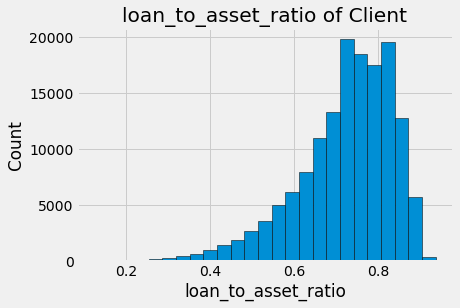

In [17]:
# Plot the distribution of ages in years
plt.hist(train['loan_to_asset_ratio'], edgecolor = 'k', bins = 25)
plt.title('loan_to_asset_ratio of Client'); plt.xlabel('loan_to_asset_ratio'); plt.ylabel('Count');

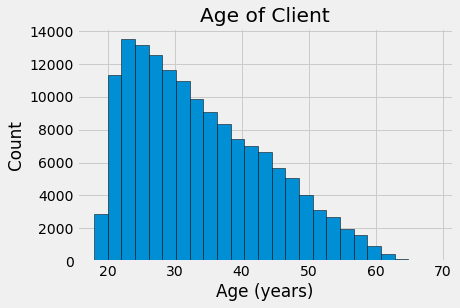

In [18]:
# Set the style of plots
plt.style.use('fivethirtyeight')

plt.hist(train['age'], edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

查看变量在不同y值上的分布（密度）

In [19]:
train.disburse_to_sactioned_ratio.sort_values(ascending=True).tail(150)

144089           7.50
43567            7.60
144771           8.14
18017            8.17
67776            8.32
             ...     
61229      2200001.00
66142      2500001.00
29117      3917746.00
108516     5490001.00
67695     50000001.00
Name: disburse_to_sactioned_ratio, Length: 150, dtype: float64

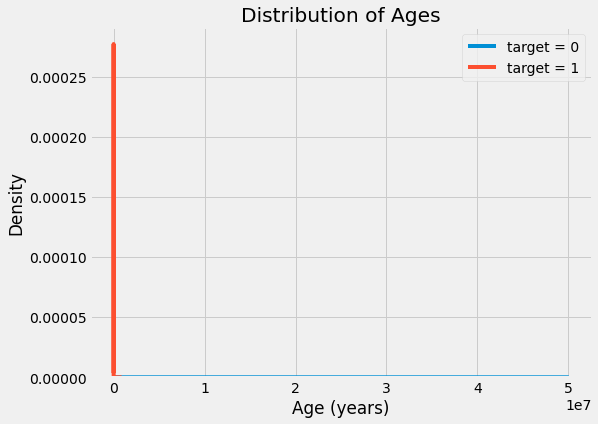

In [20]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train[target_name] == 0, 'disburse_to_sactioned_ratio'], label='target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train[target_name] == 1, 'disburse_to_sactioned_ratio'], label='target = 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend();

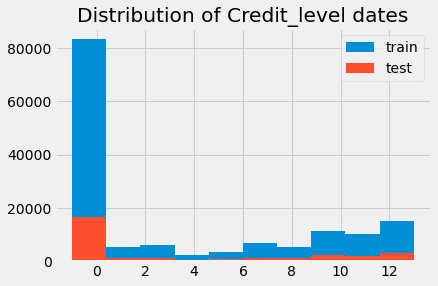

In [21]:
plt.hist(train['Credit_level'], label='train');
plt.hist(test['Credit_level'], label='test');
plt.legend();
plt.title('Distribution of Credit_level dates');

## 4. 各特征与target的相关性
- 不同特征值下target的分布/密度
- corr

In [22]:
anom = train[train['disbursed_amount'] > 150000]  # 已发放贷款金额
non_anom = train[train['disbursed_amount'] < 150000]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom[target_name].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom[target_name].mean()))
print('There are %d anomalous data of dataframe' % len(anom))

The non-anomalies default on 17.70% of loans
The anomalies default on 0.00% of loans
There are 38 anomalous data of dataframe


In [23]:
anom2 = train[train['disburse_to_sactioned_ratio'] >= 1]  # 已发放贷款金额
non_anom2 = train[train['disburse_to_sactioned_ratio'] < 1]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom2[target_name].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom2[target_name].mean()))
print('There are %d anomalous data of dataframe' % len(anom2))

The non-anomalies default on 7.67% of loans
The anomalies default on 18.09% of loans
There are 144315 anomalous data of dataframe


In [24]:
# Find correlations with the target and sort
correlations = train.astype(float).corr()[target_name].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.sort_values(ascending=False).head(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 loan_default                   1.000000
loan_to_asset_ratio            0.091999
disbursed_amount               0.073612
main_account_overdue_no        0.041032
enquirie_no                    0.040296
total_overdue_no               0.039482
year_of_birth                  0.038529
last_six_month_defaulted_no    0.034904
area_id                        0.028166
asset_cost                     0.012481
branch_id                      0.008649
supplier_id                    0.003507
main_account_tenure            0.002525
manufacturer_id                0.001685
outstanding_disburse_ratio     0.000430
Name: loan_default, dtype: float64

Most Negative Correlations:
 Credit_level                    -0.066515
credit_score                    -0.054872
age                             -0.038529
main_account_active_loan_no     -0.036846
total_account_loan_no           -0.032910
credit_history                  -0.032522
main_account_loan_no            -0.032305
last_six_mon

In [25]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = train[[target_name, 'loan_to_asset_ratio', 'disbursed_amount', 'main_account_overdue_no', 'enquirie_no',\
                 'Credit_level','credit_score','age','main_account_active_loan_no']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,loan_default,loan_to_asset_ratio,disbursed_amount,main_account_overdue_no,enquirie_no,Credit_level,credit_score,age,main_account_active_loan_no
loan_default,1.000000,0.091999,0.073612,0.041032,0.040296,-0.066515,-0.054872,-0.038529,-0.036846
loan_to_asset_ratio,0.091999,1.000000,0.402979,0.052415,0.082016,0.073920,0.086298,0.080648,0.088043
disbursed_amount,0.073612,0.402979,1.000000,0.020295,0.035272,0.004713,0.012420,-0.059068,0.040867
main_account_overdue_no,0.041032,0.052415,0.020295,1.000000,0.062966,-0.009501,0.105807,0.141705,0.375532
enquirie_no,0.040296,0.082016,0.035272,0.062966,1.000000,0.132802,0.151180,-0.003802,0.195539
Credit_level,-0.066515,0.073920,0.004713,-0.009501,0.132802,1.000000,0.975831,0.143296,0.382883
credit_score,-0.054872,0.086298,0.012420,0.105807,0.151180,0.975831,1.000000,0.169199,0.471000
age,-0.038529,0.080648,-0.059068,0.141705,-0.003802,0.143296,0.169199,1.000000,0.145950
main_account_active_loan_no,-0.036846,0.088043,0.040867,0.375532,0.195539,0.382883,0.471000,0.145950,1.000000


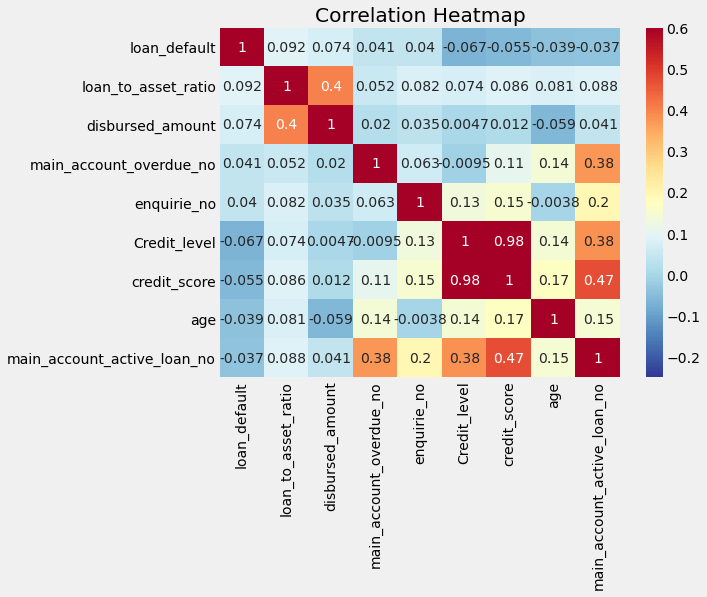

In [26]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

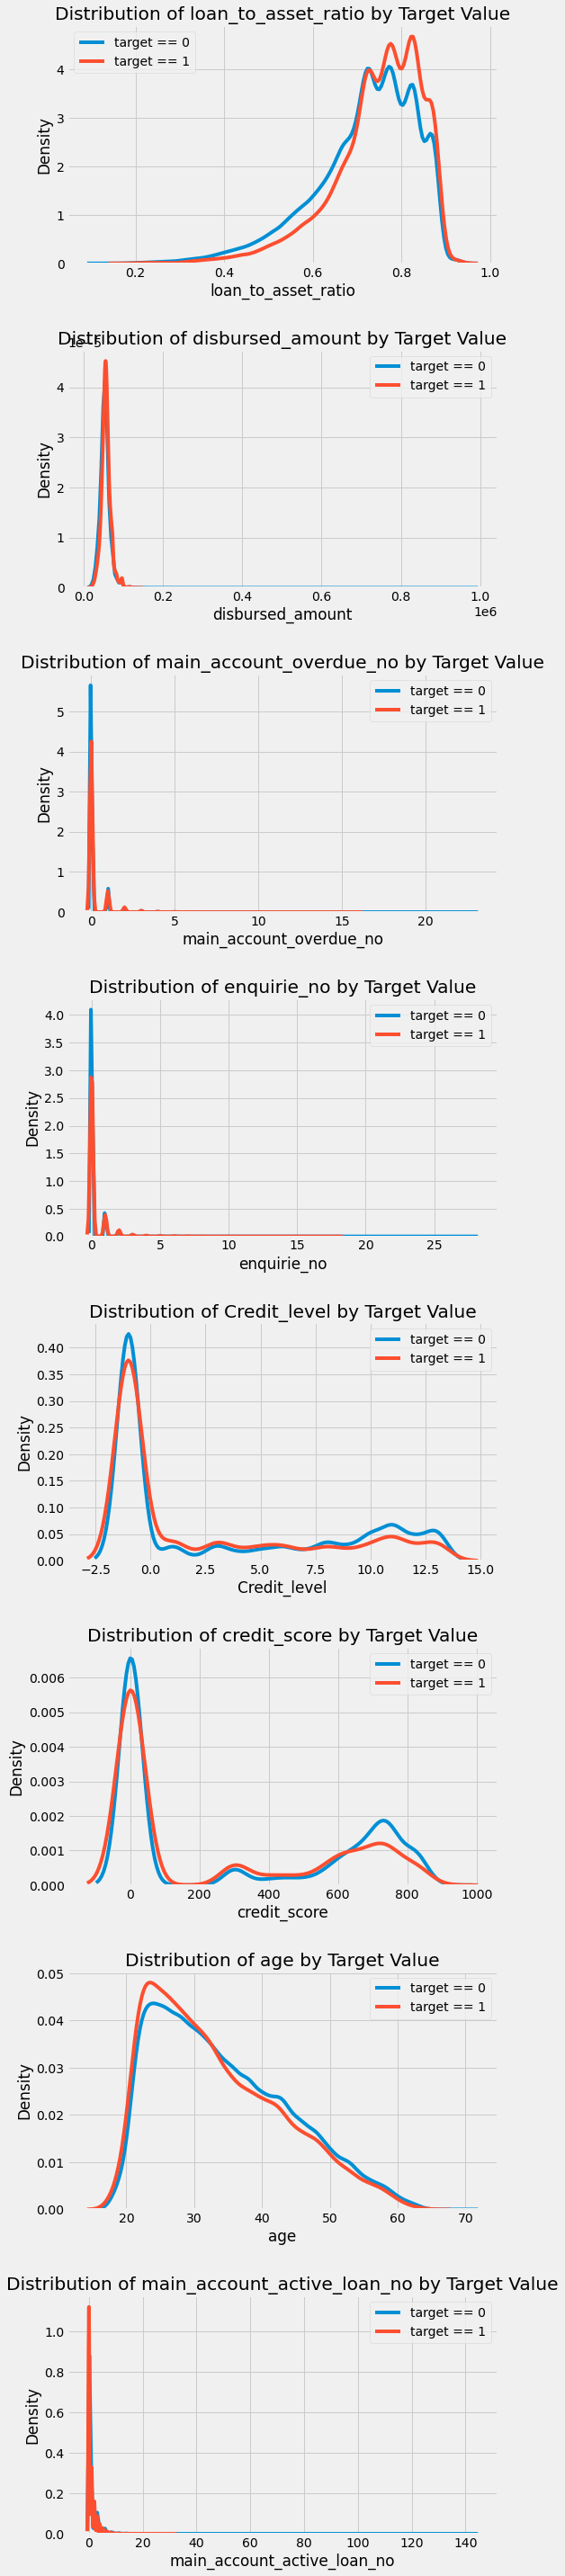

In [27]:
plt.figure(figsize = (8, 40))

# iterate through the sources
for i, source in enumerate(['loan_to_asset_ratio', 'disbursed_amount', 'main_account_overdue_no', 'enquirie_no',\
                 'Credit_level','credit_score','age','main_account_active_loan_no']):
    
    # create a new subplot for each source
    plt.subplot(8, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train[target_name] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train[target_name] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

In [28]:
# plot_data = train[[target_name, 'loan_to_asset_ratio', 'disbursed_amount','Credit_level','age']]
# sns.pairplot(plot_data,hue=target_name);

## 5. pandas_profiling生成数据报告

In [29]:
# import pandas_profiling
# pfr = pandas_profiling.ProfileReport(train)
# pfr.to_file("./example.html")

# **Feature Engineering**
- 基础特征构造
- 特征变换&特征衍生
- 特征过滤
- 特征选择

- 数据预处理
    - 缺失值的填充
    - 时间格式处理
    - 对象类型特征转换到数值
- 异常值处理
    - 基于3segama原则
    - 基于箱型图
- 数据分箱
    - 固定宽度分箱
    - 分位数分箱
        - 离散数值型数据分箱
        - 连续数值型数据分箱
    - 卡方分箱（选做作业）
- 特征交互
    - 特征和特征之间组合
    - 特征和特征之间衍生
    - 其他特征衍生的尝试（选做作业）
- 特征编码
    - one-hot编码
    - label-encode编码
- 特征选择
    - 1 Filter
    - 2 Wrapper （RFE）
    - 3 Embedded

category type
- branch_id: 发放贷款的分行
- supplier_id: 发放贷款的车辆经销商
- manufacturer_id: 汽车制造商
- area_id: 付款区域
- employee_code_id: 记录付款的对接员工
- mobileno_flag: 是否填写手机号
- idcard_flag: 是否填写身份证
- Driving_flag: 是否出具驾驶证
- passport_flag: 是否填写护照

- Credit_level: 信用评分

- employment_type: 工作类型

In [30]:
train.head()

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.50,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.33,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.00,1991,2019,13,1,28,0
3,54688,43,13,6,1867106,2484678,2486856,0,0,0,...,0,0,1.00,1.42,1964,2019,3,1,55,0
4,63894,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1995,2019,-1,0,24,0


In [31]:
# # 单次切割数据集
# folds = 4
# seed = 2021
# kf = KFold(n_splits=folds, random_state=seed, shuffle=True)
# for train_1, train_2 in kf.split(train):
#     print(train_1,train_2)
#     break

# train_a = train.loc[train_1,:]
# train_b = train.loc[train_2,:]
# train_a

In [32]:
# 只有一个值的特征（没用）
one_value_fea

['mobileno_flag', 'idcard_flag', 'disbursed_date']

In [33]:
# 类别特征（除去one_value_fea）
cat_features = ['branch_id','supplier_id','manufacturer_id','area_id','employee_code_id','Credit_level']

## 特征交互
- 组合
- 衍生

In [34]:
# # 汇总主&二级账户特征
# train['total_account_active_loan_no'] = train['main_account_active_loan_no'] + train['sub_account_active_loan_no']  # 所有账户贷款数量
# train['total_account_tenure'] = train['main_account_tenure'] + train['sub_account_tenure']  # 所有账户还款期数
# train['last_six_month_bad'] = train['last_six_month_new_loan_no']+train['last_six_month_defaulted_no']  # 过去6个月贷款数量+违约数
# train['monthly_payment_per_loan'] = train['total_monthly_payment']/train['total_account_active_loan_no']  # 平均每个贷款的月供

# train['asset_cost_loss'] = train['asset_cost'] + train['disbursed_amount']
# train['loan_to_asset_ratio'] * train['asset_cost']
# train['disbursed_amount']/train['loan_to_asset_ratio']  #已发放贷款&贷款资产比例

# 平方
# train['loan_to_asset_ratio_sq']=train['loan_to_asset_ratio']*train['loan_to_asset_ratio']
# train['last_six_month_bad_sq'] = train['last_six_month_bad'] * train['last_six_month_bad']
# train['enquirie_no_sq'] = train['enquirie_no']*train['enquirie_no']


In [35]:
for fea in cat_features:
    print(train[fea].value_counts())

42    8565
11    7323
26    6039
9     5797
10    5581
      ... 
70     112
57     111
69      95
81      55
78      39
Name: branch_id, Length: 82, dtype: int64
38      898
40      814
114     809
18      804
2       784
       ... 
2931      1
2897      1
2769      1
2197      1
2878      1
Name: supplier_id, Length: 2888, dtype: int64
2    70830
1    36281
5    17466
4    10594
0     6563
3     6231
6     1511
7      512
8        8
9        4
Name: manufacturer_id, dtype: int64
2     28910
0     22159
1     21577
6     11324
7     10216
16     9103
4      6565
13     5990
5      5792
10     4341
14     4279
11     3448
17     3298
18     2697
8      2615
9      2595
15     2370
3      1773
12      673
20      129
19       95
21       51
Name: area_id, dtype: int64
159     342
395     311
65      307
321     260
1053    253
       ... 
3202      1
2926      1
3222      1
3248      1
3151      1
Name: employee_code_id, Length: 3241, dtype: int64
-1     83316
 11    10400
 13     9206

In [36]:
cat_features

['branch_id',
 'supplier_id',
 'manufacturer_id',
 'area_id',
 'employee_code_id',
 'Credit_level']

In [37]:
# # for fea in cat_features:
# #     temp = train.groupby([fea])[target_name].agg(['mean']).reset_index().rename(columns={'mean': fea + '_target_mean'})
    
# for col in cat_features: 
#     temp_dict = train_a.groupby([col])[target_name].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
#     temp_dict.index = temp_dict[col].values
#     temp_dict = temp_dict[col + '_target_mean'].to_dict()

#     train_a[col + '_target_mean'] = train_a[col].map(temp_dict)
# #     data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

# ## train_b
# for col in cat_features: 
#     temp_dict = train_b.groupby([col])[target_name].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
#     temp_dict.index = temp_dict[col].values
#     temp_dict = temp_dict[col + '_target_mean'].to_dict()

#     train_b[col + '_target_mean'] = train_b[col].map(temp_dict)

In [38]:
cat_features_target_info = ['branch_id_target_mean', 'supplier_id_target_mean',
       'manufacturer_id_target_mean', 'area_id_target_mean',
       'employee_code_id_target_mean','Credit_level_target_mean']

In [39]:
# train_a

In [40]:
# train_cat_fea = train_a[cat_features]
# train_cat_fea[cat_features_target_info] = train_a[cat_features_target_info]
# train_cat_fea


# # train_cat_fea_b = train_b[cat_features]
# # train_cat_fea_b[cat_features_target_info] = train_b[cat_features_target_info]
# # train_cat_fea_b

In [41]:
# 对test数特征做相同处理
test_cat_fea = test[[id,'branch_id','supplier_id', 'manufacturer_id','area_id', \
                    'employee_code_id', 'Credit_level']]
test_cat_fea

,customer_id,branch_id,supplier_id,manufacturer_id,area_id,employee_code_id,Credit_level
0,14342,26,602,2,5,735,1
1,94753,16,123,2,2,131,-1
2,140283,14,395,2,8,450,-1
3,134742,6,506,2,4,2108,11
4,4749,4,789,5,5,986,-1
...,...,...,...,...,...,...,...
29995,100643,59,162,3,2,175,-1
29996,166843,1,2162,0,1,1160,-1
29997,4084,8,193,2,0,154,8
29998,171136,43,67,0,0,69,9


In [42]:
# for col in cat_features:
#     test_cat_fea = test_cat_fea.merge(train_cat_fea[[col,col + '_target_mean']].drop_duplicates(),how = 'left',on =col)
# test_cat_fea

In [43]:
# 具体的查看缺失特征及缺失率
# nan可视化
missing_2 = test_cat_fea.isnull().sum()/len(train)
missing_2
# missing = missing[missing > 0]
# missing.sort_values(inplace=True)
# missing.plot.bar()

customer_id         0.0
branch_id           0.0
supplier_id         0.0
manufacturer_id     0.0
area_id             0.0
employee_code_id    0.0
Credit_level        0.0
dtype: float64

In [44]:
# new_test = pd.concat([test,test_cat_fea[cat_features_target_info]],axis=1)
# new_test

In [45]:
# 特征处理完成后看看shape(这里train_a为切分过的，所以行数不对)
# train_a.shape,new_test.shape

In [46]:
# 这个代码可以 删除变量+释放内存
# import gc
# del test_cat_fea
# gc.collect()

# **建模调参**
* 相关模型
    * **逻辑回归**
    * **Xgboost**
    * **Lightgbm**
    * Catboost
* 性能评估
    * 评估方法
    * 评价标准
* 调参
    * 贪心调参
    * **网格搜索**
    * **贝叶斯调参**


In [47]:
one_value_fea

['mobileno_flag', 'idcard_flag', 'disbursed_date']

In [48]:
# 去掉一些没有价值的变量 id, target, 唯一值变量
X = train.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','loan_default',],axis=1)
y = train['loan_default']
X_test = test.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1)

In [49]:
X.shape,y.shape,X_test.shape

((150000, 48), (150000,), (30000, 48))

In [50]:
# X_a = train_a.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','loan_default',],axis=1)
# X_b = train_b.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','loan_default',],axis=1)
# y_a = train_a['loan_default']
# y_b = train_b['loan_default']

## 定义一些训练时需要的函数
- 自定义评价标准 feval
- 分类问题，将输出的概率值按照threshold转为离散的0，1

In [52]:
a = np.array([-0.05,0,0.05,0.11,0.18,0.26,0.3,0.5,1])
a = 1.0 / (1.0 + np.exp(-a))  # transform raw leaf weight
a

array([0.4875026 , 0.5       , 0.5124974 , 0.5274723 , 0.54487889,
       0.56463629, 0.57444252, 0.62245933, 0.73105858])

In [53]:
from scipy import special, optimize
class FocalLoss:

    def __init__(self, gamma, alpha=None):
        # 使用FocalLoss只需要设定以上两个参数,如果alpha=None,默认取值为1
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        # alpha 参数, 根据FL的定义函数,正样本权重为self.alpha,负样本权重为1 - self.alpha
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        # pt和p的关系
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        # 即FL的计算公式
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        # 一阶导数
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        # 二阶导数
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        # 样本初始值寻找过程
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

In [54]:
# def f1_loss(y, pred):
#     beta = 2
#     p = 1 / (1 + np.exp(-pred))
#     grad = p * ((beta - 1) * y + 1) - beta * y
#     hess = ((beta - 1) * y + 1) * p * (1.0 - p)
 
#     return grad, hess
def f1_loss(y, pred):
    beta = 2
    p = 1. / (1 + np.exp(-pred))
    grad = p * ((beta - 1) * y + 1) - beta * y
    hess = ((beta - 1) * y + 1) * p * (1.0 - p)
 
    return grad, hess

def logloss_objective(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    grad = p - y
    hess = p * (1 - p)
    return grad, hess

In [55]:
def prob_to_label(x,threshold):
    labels = x.copy()
    labels[labels<threshold]=0
    labels[labels>=threshold]=1
    return labels

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, dtrain):
    labels = dtrain.get_label()
    return 'RMSPE', round(rmspe(labels, preds),5), False


def c_f1_score(labels, preds, beta=1, log_like=False):
    EPS = 1e-10
    # print(prediction)
    N = preds.size
    TP = (preds * labels).sum()
#     TP = np.logical_and(prediction,target).sum()
    H = beta * labels.sum() + preds.sum()
    fmeasure = (1 + beta) * TP / (H + EPS)
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_  = (1 - fmeasure)
    return floss_

def c_f1_macro_score(labels, preds, beta=1, log_like=False):
    EPS = 1e-10
    preds_inv = np.logical_not(preds)
    labels_inv = np.logical_not(labels)
    
    TP_0 = (preds_inv * labels_inv).sum()
    H_0 = beta * labels_inv.sum() + preds_inv.sum()
    fmeasure_0 = (1 + beta) * TP_0 / (H_0 + EPS)
    
    TP_1 = (preds * labels).sum()
    H_1 = beta * labels.sum() + preds.sum()
    fmeasure_1 = (1 + beta) * TP_1 / (H_1 + EPS)
    
    fmeasure = (fmeasure_0 + fmeasure_1)/2
    if log_like:
        floss_ = torch.log(fmeasure)
    else:
        floss_ = fmeasure
    return floss_

    
def f1_score_custom(y_true, y_pred):
    y_pred = y_pred.round()
    return 'f1', f1_score(y_true, y_pred,average='macro'), True

def feval_f1(preds, dtrain, threshold):
    labels = dtrain.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    return 'f1', -round(c_f1_score(labels, preds),5), False  # Maximize=False

def feval_f1_macro(preds, dtrain):  #注意preds要放前面，我也不知道为什么，否则会报错ndarray has no...get_label()
    labels = dtrain.get_label()
    preds = prob_to_label(preds, threshold=threshold)
    return 'f1_macro', -round(c_f1_macro_score(labels, preds),5), False

def feval_f1_macro_2(preds, dtrain):
    labels = dtrain.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    # 基于sklearn 的f1_score实现，速度较慢
    return 'f1_macro_sklearn', -round(f1_score(labels, preds, average='macro'),5), False

def feval_f1_macro_xgb(preds, dtrain):
    labels = dtrain.get_label()
    preds = prob_to_label(preds, threshold=threshold)
    return 'f1_macro', -round(c_f1_macro_score(labels, preds),5)

def feval_f1_macro_xgb_2(preds, dtrain):
    labels = dtrain.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    # 基于sklearn 的f1_score实现，速度较慢
    return 'f1_macro_sklearn', -round(f1_score(labels, preds, average='macro'),5)

def logreg_obj(preds, dtrain):  # this is loglikelihood loss
    labels = dtrain.get_label()
    preds = prob_to_label(preds)
    grad = preds - labels  # 一阶梯度
    hess = preds*(1-preds) # 二阶梯度
    return grads, hess

def feval_f1_xgb_2(preds, dtrain):
    EPS = 1e-10
    labels = dtrain.get_label()
    
    preds = 1.0 / (1.0+np.exp(-preds))
    pred = [int (i>=0.5) for i in preds]
    tp = sum([int(i==1 and j==1) for i,j in zip(pred,labels)])
    precision = float(tp)/(sum(pred)+EPS)
    recall = float(tp)/(sum(labels)+EPS)
    
    return 'f1-score', -1*(precision*recall/(precision+recall))


def get_f1 (preds,dtrain):  # multi_class
    label=dtrain.get_label()
    preds= np.argmax(preds.reshape(12, -1), axis=0)
    f1=f1_score(label,preds,average='weighted')
    return '1-f1_score',1-float(f1)


def f1_metric(preds,dtrain):
    labels = dtrain.get_label()
    preds = prob_to_label(preds, threshold=threshold)
    
    precision = sum(labels==1 & preds==1)/sum(labels)
    recall    = sum(labels==1 & preds==1)/sum(preds)
    f1 = 2 * precision * recall / (precision + recall)
    return '-f1', -round(f1,5)

def f1_macro_metric(preds,dtrain):
    labels = dtrain.get_label()
    preds = prob_to_label(preds, threshold=threshold)
    
    precision_0 = sum(labels==0 & preds==0)/(len(labels)-sum(labels))
    recall_0    = sum(labels==0 & preds==0)/(len(labels)-sum(labels))
    
    precision_1 = sum(labels==1 & preds==1)/sum(labels)
    recall_1    = sum(labels==1 & preds==1)/sum(preds)
    f1 = 2 * precision * recall / (precision + recall)
    return '-f1_macro', -round(f1,5)


In [85]:
lgb_params = {
            # Parameters_a 
            'objective': 'binary',
            'boosting': 'gbdt', # 'dart'
            'metric': 'auc',
            # 'num_iterations':100,  # default=100,构建的树的数量
            # 'max_bin': 255,
            'learning_rate': 0.01,
            
            'max_depth': 10,
            'num_leaves': 2 ** 7,  # default = 31(2**5-1)
            # 'min_data_in_leaf': 20 ,# default = 20
            'min_child_weight': 1e-3,# default=1e-3,min_sum_hessian_in_leaf
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 4,
            
            # 'lambda_l1':0,
            'lambda_l2': 10,
            # 'min_gain_to_split':0,

            'n_jobs': -1, # 'n_jobs'
#             'device':cpu,  # gpu, cuda
            'seed': 2021,
            'verbosity': -1,
            # 'is_unbalance':false  # true
        }

xgb_params={'objective': 'binary:logistic',
            'booster': 'gbtree', # default=gbtree, others:gblinear,dart
            'eval_metric':'auc',
            'learning_rate': 0.01,  # eta,default=0.3
            
            'max_depth':10, 
            # 'min_child_weight':1,  # default=1, 
            'min_split_loss':0,  # default=0
            # 'max_dalta_step':0,  #default=0,类别不平衡时使用
            'subsample':0.9,
            'colsample_bytree':0.9,
            'alpha':0,
            'lambda':10,
            'tree_method':'auto',# default='auto'   'exact'
            
            'nthread':-1,
            'seed':2021,
            'verbosity':1,  # 0 (silent), 1 (warning), 2 (info), 3 (debug)
}

xgb_params_2={'objective': 'binary:logistic',
            'booster': 'gbtree', # default=gbtree, others:gblinear,dart
#             'eval_metric':'auc',
            'learning_rate': 0.01,  # eta,default=0.3
            
            'max_depth':10, 
            # 'min_child_weight':1,  # default=1, 
            'min_split_loss':0,  # default=0
            # 'max_dalta_step':0,  #default=0,类别不平衡时使用
            'subsample':0.9,
            'colsample_bytree':0.9,
            'alpha':0,
            'lambda':10,
            'tree_method':'auto',# default='auto'   'exact'
            
            'nthread':-1,
            'seed':2021,
            'verbosity':1,  # 0 (silent), 1 (warning), 2 (info), 3 (debug)
}

cat_params = {'learning_rate': 0.05,
              'depth': 7,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 2021,
              'allow_writing_files': False
}

In [86]:
oof = pd.DataFrame()                 # out-of-fold result

threshold = 0.25

# thresholds = [0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,
#               0.246,0.247,0.248, 0.249,0.250,0.251,0.252,0.253]
models = []                          # models


def cv_model(clf, X, y, clf_name, num_folds=5, stratified = False):
    auc_scores = []
    f1_macro_scores = []
    
    # precision_list = []
    # recall_list = []
    # confusion_matrix_list = []

#     print("Starting {}. Train shape: {}, test shape: {}".format(clf, X.shape, test_df.shape))
    seed = 2021
    if stratified:
        kf = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            # fl = FocalLoss(alpha=0.9, gamma=0.05)
#             weights = y_train + 1 
            train_matrix = clf.Dataset(X_train,y_train)
#             weights = y_valid + 1 
            valid_matrix = clf.Dataset(X_valid,y_valid,reference = train_matrix)

            model = clf.train(params=lgb_params,  # bayes_lgb_params
                              train_set=train_matrix,
                              valid_sets=[train_matrix, valid_matrix],
                              feval = feval_f1_macro,
#                               feval = fl.lgb_eval,
#                               fobj = f1_loss,
#                               fobj = fl.lgb_obj,
                              num_boost_round=5000,
                              early_stopping_rounds=200, 
                              verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            y_pred = model.predict(X_valid, num_iteration=model.best_iteration)            
            y_pred_ = prob_to_label(y_pred,threshold)

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              evals=watchlist,
                              feval=feval_f1_macro_xgb,
#                               feval=f1_macro_scores,
                              # maximize=True, 默认最小化评价函数feval
                              num_boost_round=5000,
                              early_stopping_rounds=200,
                              verbose_eval=200)
            #print('get_label: ',train_matrix.get_label())
            #print('get_label_sum', np.sum(np.array(train_matrix.get_label())))
            y_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            #print('pred_pro',y_pred)
            # preds = model.predict(valid_matrix, ntree_limit=bst.best_iteration)
            y_pred_ = prob_to_label(y_pred,threshold)
            #print('pred',y_pred_)
            #print('sum_of_1',np.sum(np.array(y_pred_)))
            
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            y_pred  = model.predict(X_valid)
            y_pred_ = prob_to_label(y_pred,threshold)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

        auc_scores.append(roc_auc_score(y_valid, y_pred))
        f1_macro_scores.append(f1_score(y_valid, y_pred_,average='macro'))
        
        print('auc of {} Folds: {}'.format(fold+1, round(auc_scores[fold],5)))
        print('f1_macro of {} Folds: {}'.format(fold+1, round(f1_macro_scores[fold],5)))

    print('auc_scores: ', auc_scores)
    print('auc_scores', round(np.average(np.array(auc_scores)),5))
    print('f1_macro_scores: ', f1_macro_scores) 
    print('f1_macro_scores', round(np.average(np.array(f1_macro_scores)),5))

In [87]:
threshold = 0.25

# thresholds = [0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,
#               0.246,0.247,0.248, 0.249,0.250,0.251,0.252,0.253]
models = []                          # models

def cv_model_2(clf, X, y, clf_name, num_folds=5, stratified = False):
    auc_scores = []
    f1_macro_scores = []
    valid_pred_all = np.zeros(X.shape[0])
    valid_pred_all_ = np.zeros(X.shape[0])

    # precision_list = []
    # recall_list = []
    # confusion_matrix_list = []

#     print("Starting {}. Train shape: {}, test shape: {}".format(clf, X.shape, test_df.shape))
    seed = 2021
    if stratified:
        kf = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            # fl = FocalLoss(alpha=0.9, gamma=0.05)
#             weights = y_train + 1 
            train_matrix = clf.Dataset(X_train,y_train)
#             weights = y_valid + 1 
            valid_matrix = clf.Dataset(X_valid,y_valid,reference = train_matrix)

            model = clf.train(params=lgb_params,  # bayes_lgb_params
                              train_set=train_matrix,
                              valid_sets=[train_matrix, valid_matrix],
                              # feval = feval_f1_macro,
#                               feval = fl.lgb_eval,
#                               fobj = f1_loss,
#                               fobj = fl.lgb_obj,
                              num_boost_round=5000,
                              early_stopping_rounds=200, 
                              verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            # y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
            valid_pred_all[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            # test_pred = model.predict(test_x, num_iteration=model.best_iteration)

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              evals=watchlist,
#                               feval=feval_f1_macro_xgb,
                              # maximize=True, 默认最小化评价函数feval
                              num_boost_round=5000,
                              early_stopping_rounds=200,
                              verbose_eval=200)

            valid_pred_all[val_idx] = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit) # bst.best_iteration
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            # test_pred = model.predict(xgb.DMatrix(X_test) , ntree_limit=model.best_ntree_limit)
            
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            valid_pred_all[val_idx]  = model.predict(X_valid)
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            test_pred = model.predict(test_x)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

        auc_scores.append(roc_auc_score(y_valid, valid_pred_all[val_idx]))
        f1_macro_scores.append(f1_score(y_valid, valid_pred_all_[val_idx],average='macro'))
    print('auc_scores: ', auc_scores)
    print('auc_scores', round(np.average(np.array(auc_scores)),5))
    print('f1_macro_scores: ', f1_macro_scores) 
    print('f1_macro_scores', round(np.average(np.array(f1_macro_scores)),5))
    print('Below scores is computing with valid_pred_all'+'*'*100)
    print('auc of {} folds valid_data: {}'.format(kf.n_splits, round(roc_auc_score(y,valid_pred_all),5)))
    print('f1_macro of {} folds valid_data: {}'.format(kf.n_splits, round(f1_score(y,valid_pred_all_,average='macro'),5)))

In [88]:
threshold = 0.25

# thresholds = [0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,
#               0.246,0.247,0.248, 0.249,0.250,0.251,0.252,0.253]

models = []
def cv_model_with_pred(clf, X, y, X_test, clf_name, num_folds=5, stratified = False):
    auc_scores = []
    f1_macro_scores = []
    valid_pred_all = np.zeros(X.shape[0])
    valid_pred_all_ = np.zeros(X.shape[0])
    test_pred_all = np.zeros(X_test.shape[0])
    target_arr = np.zeros(len(X_test))
    

    
    seed = 2021
    if stratified:
        kf = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            train_matrix = clf.Dataset(X_train,y_train)
            valid_matrix = clf.Dataset(X_valid,y_valid,reference = train_matrix)

            model = clf.train(params=lgb_params,  # bayes_lgb_params
                              train_set=train_matrix,
                              valid_sets=[train_matrix, valid_matrix],
                              # feval = feval_f1_macro,
                              # fobj = f1_loss,
                              num_boost_round=5000,
                              early_stopping_rounds=200, 
                              verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            # y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
            valid_pred_all[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            
            test_pred = model.predict(X_test, num_iteration=model.best_iteration)
            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              evals=watchlist,
                              # feval=feval_f1_macro_xgb,
                              # maximize=True, 默认最小化评价函数feval
                              num_boost_round=5000,
                              early_stopping_rounds=200,
                              verbose_eval=200)

            valid_pred_all[val_idx] = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit) # bst.best_iteration
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            
            test_pred = model.predict(xgb.DMatrix(X_test) , ntree_limit=model.best_ntree_limit)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            valid_pred_all[val_idx]  = model.predict(X_valid)
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            
            test_pred = model.predict(X_test)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)
        
        test_pred_all += test_pred / kf.n_splits

    print('auc of {} folds valid_data: {}'.format(kf.n_splits, round(roc_auc_score(y,valid_pred_all),5)))
    print('f1_macro of {} folds valid_data: {}'.format(kf.n_splits, round(f1_score(y,valid_pred_all_,average='macro'),5)))
    
    return valid_pred_all, test_pred_all

In [89]:
def lgb_model(x_train, y_train):
    lgb_train = cv_model(lgb, x_train, y_train, "lgb")
    return lgb_train
def xgb_model(x_train, y_train):
    xgb_train = cv_model(xgb, x_train, y_train, "xgb")
    return xgb_train
def cat_model(x_train, y_train):
    cat_train = cv_model(CatBoostRegressor, x_train, y_train,"cat")
    return cat_train
def lgb_model_2(x_train, y_train):
    lgb_train = cv_model_2(lgb, x_train, y_train, "lgb")
    return lgb_train
def xgb_model_2(x_train, y_train):
    xgb_train = cv_model_2(xgb, x_train, y_train, "xgb")
    return xgb_train
def cat_model_2(x_train, y_train):
    cat_train = cv_model_2(CatBoostRegressor, x_train, y_train,"cat")
    return cat_train

# def lgb_model_with_predict(x_train, y_train, x_test):
#     lgb_train, lgb_test = cv_model_with_pridict(lgb, x_train, y_train, x_test, "lgb")
#     return lgb_train, lgb_test

# def xgb_model_with_predict(x_train, y_train, x_test):
#     xgb_train, xgb_test = cv_model_with_pridict(xgb, x_train, y_train, x_test, "xgb")
#     return xgb_train, xgb_test

# def cat_model_with_predict(x_train, y_train, x_test):
#     cat_train, cat_test = cv_model_with_pridict(CatBoostRegressor, x_train, y_train, x_test, "cat")

def lgb_model_with_pred(X, y, X_test):
    lgb_train, lgb_test = cv_model_with_pred(lgb, X, y, X_test, "lgb")
    return lgb_train, lgb_test

def xgb_model_with_pred(X, y, X_test):
    xgb_train, xgb_test = cv_model_with_pred(xgb, X, y, X_test, "xgb")
    return xgb_train, xgb_test

def cat_model_with_pred(X, y, X_test):
    cat_train, cat_test = cv_model_with_pred(CatBoostRegressor, X, y, X_test, "cat")
    return cat_train, cat_test

In [90]:
%%time
lgb_train = lgb_model(X, y)
# xgb_train = xgb_model(X, y)
# cat_train = cat_model(X, y)

Fold : 1
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.708086	training's f1_macro: -0.60126	valid_1's auc: 0.655482	valid_1's f1_macro: -0.5611
[400]	training's auc: 0.738124	training's f1_macro: -0.63757	valid_1's auc: 0.663162	valid_1's f1_macro: -0.58089
[600]	training's auc: 0.760729	training's f1_macro: -0.65645	valid_1's auc: 0.665385	valid_1's f1_macro: -0.58154
[800]	training's auc: 0.777987	training's f1_macro: -0.67034	valid_1's auc: 0.665948	valid_1's f1_macro: -0.58294
[1000]	training's auc: 0.793562	training's f1_macro: -0.68245	valid_1's auc: 0.665686	valid_1's f1_macro: -0.58362
[1200]	training's auc: 0.807115	training's f1_macro: -0.69404	valid_1's auc: 0.665536	valid_1's f1_macro: -0.58309
Early stopping, best iteration is:
[795]	training's auc: 0.777513	training's f1_macro: -0.66999	valid_1's auc: 0.665994	valid_1's f1_macro: -0.58302
***********************************************************************************************

In [91]:
%%time
lgb_train = lgb_model_2(X, y)
# xgb_train = xgb_model_2(X, y)
# cat_train = cat_model_2(X, y)

Fold : 1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.708086	valid_1's auc: 0.655482
[400]	training's auc: 0.738124	valid_1's auc: 0.663162
[600]	training's auc: 0.760729	valid_1's auc: 0.665385
[800]	training's auc: 0.777987	valid_1's auc: 0.665948
Early stopping, best iteration is:
[795]	training's auc: 0.777513	valid_1's auc: 0.665994
****************************************************************************************************
Fold : 2
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.70769	valid_1's auc: 0.654586
[400]	training's auc: 0.737329	valid_1's auc: 0.661138
[600]	training's auc: 0.758775	valid_1's auc: 0.663817
[800]	training's auc: 0.776032	valid_1's auc: 0.664675
[1000]	training's auc: 0.791711	valid_1's auc: 0.665079
[1200]	training's auc: 0.806199	valid_1's auc: 0.664679
Early stopping, best iteration is:
[1023]	training's auc: 0.793377	valid_1's auc: 0.665149
*************************

In [92]:
%%time
# lgb_train = lgb_model(X, y)
xgb_train = xgb_model(X, y)  # 过拟合严重，以f1_macro_xgb做为评价指标，没有改进效果（性能反而下降）

Fold : 1
[0]	train-auc:0.63029	train-f1_macro:-0.45164	eval-auc:0.61814	eval-f1_macro:-0.45074
[200]	train-auc:0.74051	train-f1_macro:-0.45292	eval-auc:0.65021	eval-f1_macro:-0.45092
[400]	train-auc:0.78595	train-f1_macro:-0.45653	eval-auc:0.66067	eval-f1_macro:-0.45206
[600]	train-auc:0.80996	train-f1_macro:-0.46289	eval-auc:0.66386	eval-f1_macro:-0.45262
[800]	train-auc:0.82773	train-f1_macro:-0.46894	eval-auc:0.66506	eval-f1_macro:-0.45317
[1000]	train-auc:0.84374	train-f1_macro:-0.47586	eval-auc:0.66556	eval-f1_macro:-0.45374
[1200]	train-auc:0.85799	train-f1_macro:-0.48382	eval-auc:0.66569	eval-f1_macro:-0.45448
[1400]	train-auc:0.87111	train-f1_macro:-0.49353	eval-auc:0.66502	eval-f1_macro:-0.45486
[1600]	train-auc:0.88209	train-f1_macro:-0.50288	eval-auc:0.66487	eval-f1_macro:-0.45544
[1800]	train-auc:0.89275	train-f1_macro:-0.51309	eval-auc:0.66434	eval-f1_macro:-0.45599
[2000]	train-auc:0.90195	train-f1_macro:-0.52426	eval-auc:0.66384	eval-f1_macro:-0.45674
[2200]	train-auc:0.

In [93]:
%%time
# lgb_train = lgb_model_2(X, y)
xgb_train = xgb_model_2(X, y)  # 0.66177/0.58142

Fold : 1
[0]	train-auc:0.63029	eval-auc:0.61814
[200]	train-auc:0.74051	eval-auc:0.65021
[400]	train-auc:0.78595	eval-auc:0.66067
[600]	train-auc:0.80996	eval-auc:0.66386
[800]	train-auc:0.82773	eval-auc:0.66506
[1000]	train-auc:0.84374	eval-auc:0.66556
[1200]	train-auc:0.85799	eval-auc:0.66569
[1253]	train-auc:0.86177	eval-auc:0.66553
****************************************************************************************************
Fold : 2
[0]	train-auc:0.62734	eval-auc:0.61554
[200]	train-auc:0.73970	eval-auc:0.65147
[400]	train-auc:0.78175	eval-auc:0.66155
[600]	train-auc:0.80602	eval-auc:0.66495
[800]	train-auc:0.82304	eval-auc:0.66612
[1000]	train-auc:0.83960	eval-auc:0.66654
[1200]	train-auc:0.85528	eval-auc:0.66669
[1371]	train-auc:0.86669	eval-auc:0.66642
****************************************************************************************************
Fold : 3
[0]	train-auc:0.62734	eval-auc:0.61675
[200]	train-auc:0.73902	eval-auc:0.65117
[400]	train-auc:0.78427	eval-auc:

In [94]:
# %%time
# lgb_train, lgb_test = lgb_model_with_pred(X, y, X_test)

In [95]:
# %%time
# # lgb_train, lgb_test = lgb_model_with_predict(X, y, X_test)
# xgb_train, xgb_test = xgb_model_with_pred(X, y, X_test)

## feature importance

In [96]:
models

Text(0, 0.5, 'Feature')

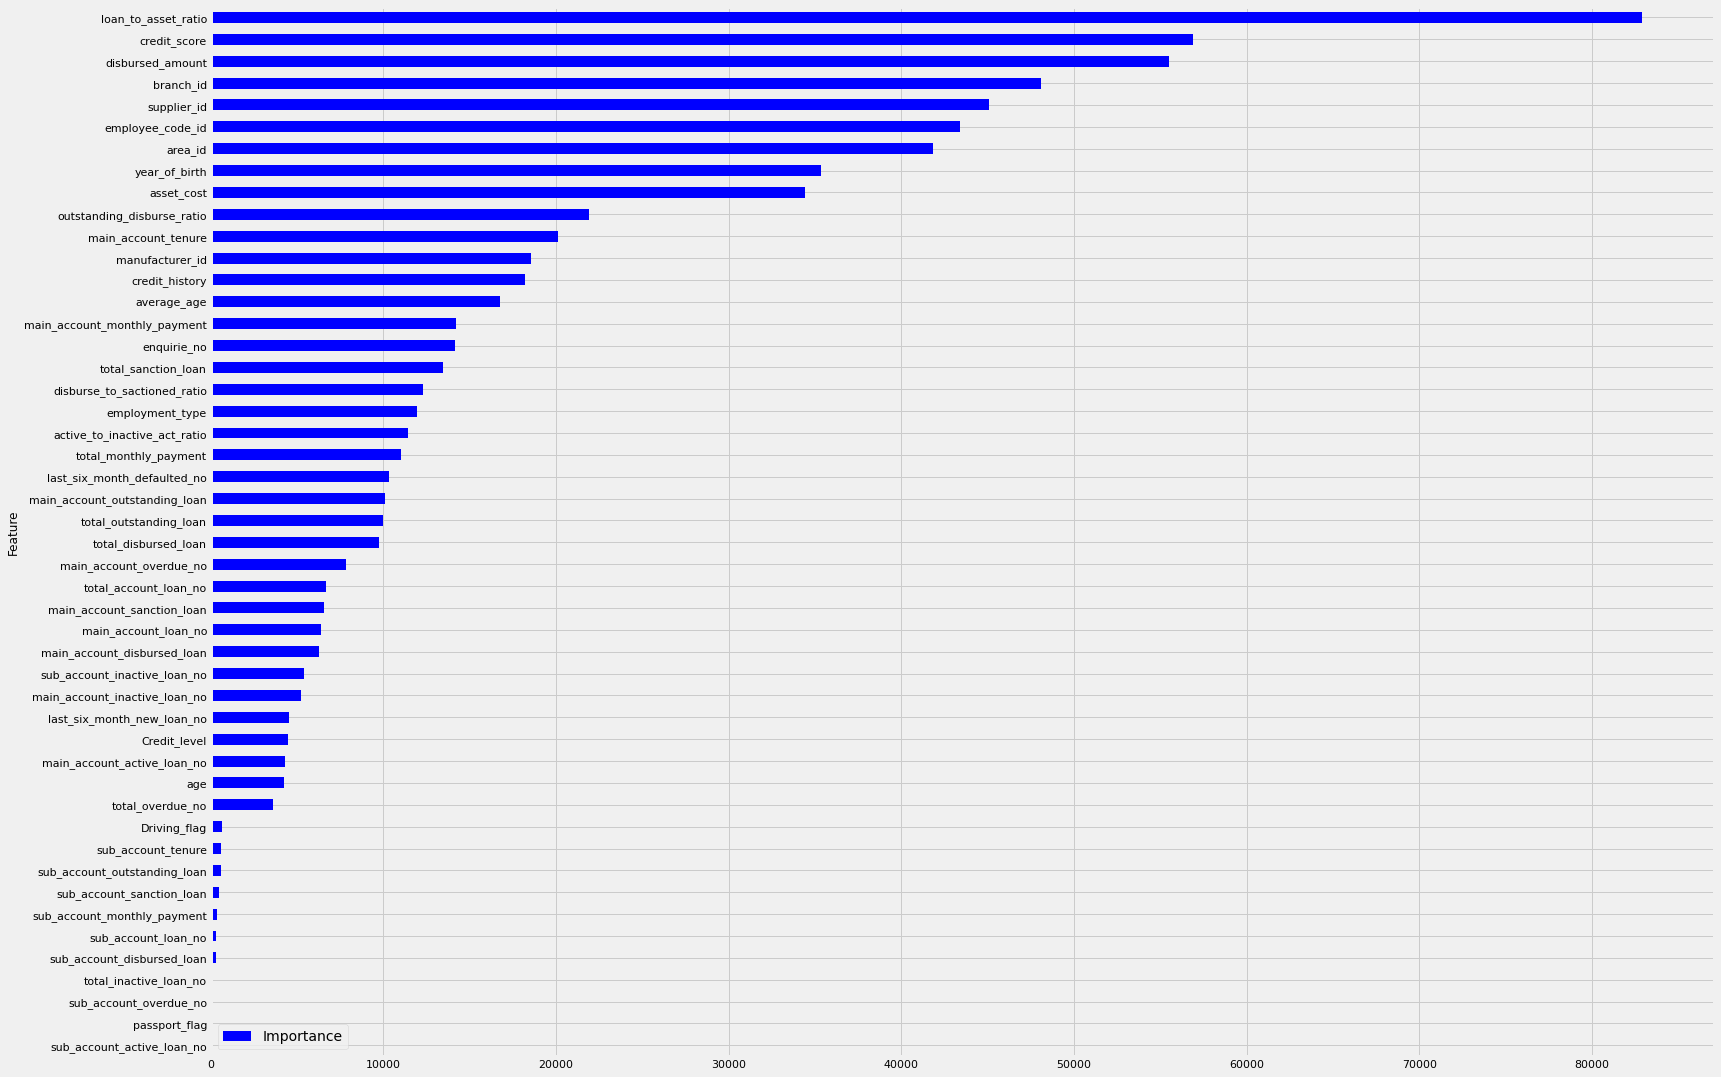

In [97]:
# lgb - plot feature importance
importances = pd.DataFrame({'Feature': models[0].feature_name(), 
                            'Importance': models[0].feature_importance(importance_type='gain')})
importances.sort_values(by = 'Importance', inplace=True)
importances2 = importances.nlargest(80,'Importance', keep='first').sort_values(by='Importance', ascending=True)
importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (24,18), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

In [98]:
importances.sort_values(by='Importance',ascending=False).head(5).append(importances.sort_values(by='Importance',ascending=False).tail(5))

,Feature,Importance
29,loan_to_asset_ratio,82908.254009
21,credit_score,56901.129778
12,disbursed_amount,55519.152048
14,branch_id,48088.879757
15,supplier_id,45103.894056
11,sub_account_disbursed_loan,308.815043
32,total_inactive_loan_no,137.352958
8,sub_account_overdue_no,102.091870
20,passport_flag,38.443111
7,sub_account_active_loan_no,20.754660


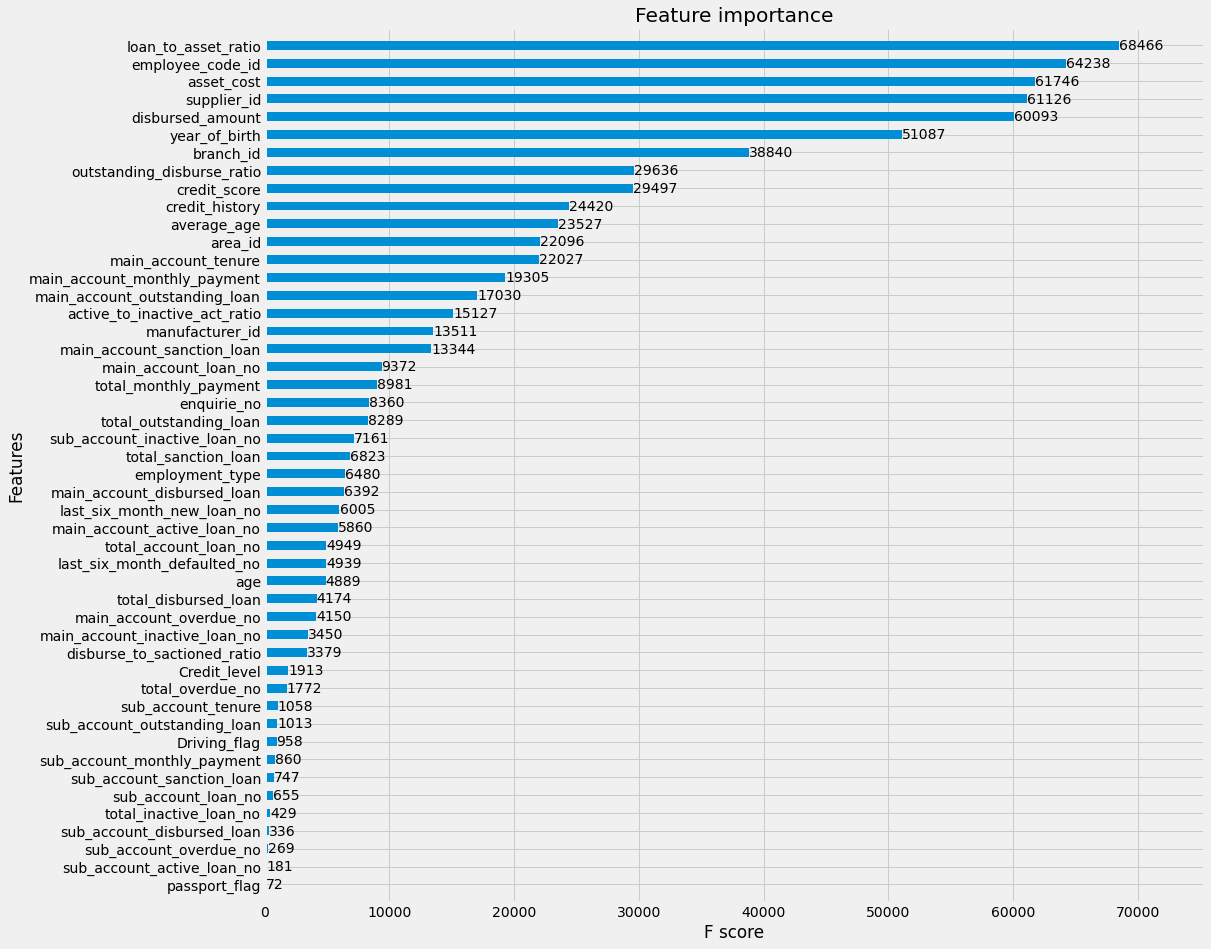

In [99]:
# xgb - plot feature importance
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(15,15))
plot_importance(models[10],
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

In [108]:
importance = models[10].get_fscore()  # dict
importance=sorted(importance.items(),key=lambda item:item[1],reverse=True)
importance

[('loan_to_asset_ratio', 68466),
 ('employee_code_id', 64238),
 ('asset_cost', 61746),
 ('supplier_id', 61126),
 ('disbursed_amount', 60093),
 ('year_of_birth', 51087),
 ('branch_id', 38840),
 ('outstanding_disburse_ratio', 29636),
 ('credit_score', 29497),
 ('credit_history', 24420),
 ('average_age', 23527),
 ('area_id', 22096),
 ('main_account_tenure', 22027),
 ('main_account_monthly_payment', 19305),
 ('main_account_outstanding_loan', 17030),
 ('active_to_inactive_act_ratio', 15127),
 ('manufacturer_id', 13511),
 ('main_account_sanction_loan', 13344),
 ('main_account_loan_no', 9372),
 ('total_monthly_payment', 8981),
 ('enquirie_no', 8360),
 ('total_outstanding_loan', 8289),
 ('sub_account_inactive_loan_no', 7161),
 ('total_sanction_loan', 6823),
 ('employment_type', 6480),
 ('main_account_disbursed_loan', 6392),
 ('last_six_month_new_loan_no', 6005),
 ('main_account_active_loan_no', 5860),
 ('total_account_loan_no', 4949),
 ('last_six_month_defaulted_no', 4939),
 ('age', 4889),
 ('

In [109]:
# train_df = train[train[target_name].notnull()]
# test_df = test[test[target_name].notnull()]
# test_df

## Predict
如果你的训练和预测是分开的话,需要在之前保存model,然后再进行预测

In [110]:
X_test

,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,sub_account_outstanding_loan,...,total_monthly_payment,outstanding_disburse_ratio,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,Credit_level,employment_type,age
0,4,1,3,75804,57000,75804,0,0,0,0,...,0,1.00,75804,0,1.33,1.25,1976,1,0,43
1,0,0,0,0,0,0,0,0,0,0,...,0,1.00,0,0,1.00,1.00,1970,-1,1,49
2,0,0,0,0,0,0,0,0,0,0,...,0,1.00,0,0,1.00,1.00,1997,-1,1,22
3,6,4,0,42100,90186,90186,0,0,0,0,...,8540,2.14,10,0,1.00,2.33,1977,11,0,42
4,0,0,0,0,0,0,0,0,0,0,...,0,1.00,0,0,1.00,1.00,1984,-1,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0,0,0,0,...,0,1.00,0,0,1.00,1.00,1998,-1,1,21
29996,1,1,0,0,10000,2049,0,0,0,0,...,0,2050.00,2049,0,0.20,2.00,1993,-1,1,26
29997,1,1,0,80300,81600,81600,0,0,0,0,...,0,1.02,81600,0,1.00,2.00,1966,8,0,53
29998,8,3,0,79447,90206,90206,0,0,0,0,...,11874,1.14,7,0,1.00,1.50,1997,9,2,22


In [111]:
target_arr = np.zeros(len(X_test))
# 由于我之前train了2次，保存了10个模型，评价和指标不同，这里只选择5个
for model in tqdm(models[:5],total=len(models[:5])):
    pred = model.predict(X_test, num_iteration=model.best_iteration)
    target_arr += pred / len(models[:5])

In [112]:
target = pd.Series(target_arr)
target

0        0.159756
1        0.085792
2        0.186234
3        0.159270
4        0.093297
           ...   
29995    0.234854
29996    0.122636
29997    0.075455
29998    0.192192
29999    0.157967
Length: 30000, dtype: float64

In [113]:
submission = pd.concat([test[id],target],axis=1)
submission.rename(columns={0:target_name},inplace=True)
submission

,customer_id,loan_default
0,14342,0.159756
1,94753,0.085792
2,140283,0.186234
3,134742,0.159270
4,4749,0.093297
...,...,...
29995,100643,0.234854
29996,166843,0.122636
29997,4084,0.075455
29998,171136,0.192192


In [114]:
threshold=0.25
submission['loan_default'] = submission['loan_default'].apply(lambda x:1 if x>threshold else 0).values
# submission = pd.DataFrame(data=target,columns=['loan_submit'])
submission['loan_default'].value_counts()

0    24537
1     5463
Name: loan_default, dtype: int64

In [115]:
submission.to_csv('lgb.csv',index=0)

# 调参（bayesian-optimization）

In [116]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

You should consider upgrading via the 'd:\program\anaconda\python.exe -m pip install --upgrade pip' command.


In [131]:
def lgb_black_box(num_leaves, 
                  max_depth, 
                  min_data_in_leaf, 
                  min_child_weight, 
                  min_gain_to_split, 
                  
                  bagging_fraction,
                  feature_fraction,
                  bagging_freq, 
                  lambda_l2, 
                  lambda_l1):
    params = {
        'num_leaves': int(num_leaves), 
        'max_depth': int(max_depth), 
        'min_data_in_leaf': int(min_data_in_leaf), 
        'min_child_weight': min_child_weight, 
        'min_gain_to_split': min_gain_to_split, 
        'bagging_freq': int(bagging_freq), 
        'bagging_fraction': bagging_fraction,
        'feature_fraction': feature_fraction,
        'lambda_l2': lambda_l2, 
        'lambda_l1': lambda_l1,
        
        'objective': 'binary',
        'boosting': 'gbdt',
        'metric': 'None',
        'learning_rate': 0.05,
        'n_estimators': 5000, # 设大一点，其实就是num_boosting_round最大迭代次数
        'verbose': -1,
        'n_jobs': -1,
        'seed': 2021,
        # 'is_unbalance': True,
        
    }
    
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)
    
    oof = np.zeros(X.shape[0])
    oof_ = np.zeros(X.shape[0])
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)

        train_data = lgb.Dataset(X.iloc[trn_idx], y[trn_idx])
        valid_data = lgb.Dataset(X.iloc[val_idx], y[val_idx])

        # model # 建立模型
        model = lgb.train(params,  # bayes_lgbm_params
                          train_data,
                          valid_sets=[train_data, valid_data],
                          feval = feval_f1_macro,
                          num_boost_round=5000,
                          early_stopping_rounds=300,
                          verbose_eval=200
    #                       categorical_feature = ['Driving_flag']        
                         )
        # validation 
        oof[val_idx] = model.predict(X.iloc[val_idx],
                                     num_iteration=model.best_iteration)
        oof_[val_idx] = prob_to_label(oof[val_idx], threshold=0.25)
        del model, trn_idx, val_idx
        gc.collect()

    # 定义评价指标
#     val = cross_val_score(model_lgb, X_train, valid_matrix, cv=5, scoring='roc_auc').mean()
#     print(oof)
    return f1_score(y,oof_,average='macro')  # 参数顺序很重要,默认对score 进行max

In [132]:
"""定义优化参数"""
lgb_BO = BayesianOptimization(
    lgb_black_box, 
    {
        'num_leaves':(10, 300),  # 128
        'max_depth':(3, 20),  # 10
        'bagging_fraction':(0.5, 1.0),  # 0.9
        'feature_fraction':(0.5, 1.0),  # 0.9
        'bagging_freq':(0,100),  # 4
        'min_data_in_leaf':(5, 100),  # default=20
        'min_child_weight':(0, 1),  # default=1e-3
        'min_gain_to_split':(0.00001, 0.1),  # default=0
        'lambda_l1':(0.0, 10),  # default=0
        'lambda_l2':(0.0, 10),  # 10
    },
    random_state = 2021
)
print(lgb_BO.space.keys)

['bagging_fraction', 'bagging_freq', 'feature_fraction', 'lambda_l1', 'lambda_l2', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'min_gain_to_split', 'num_leaves']


In [133]:
%%time
# init_points = 3
n_iter = 10

lgb_BO.maximize(# init_points = init_points,
                n_iter = n_iter)

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | min_ga... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
Fold : 1
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.59507	valid_1's f1_macro: -0.57637
[400]	training's f1_macro: -0.61518	valid_1's f1_macro: -0.57927
[600]	training's f1_macro: -0.62556	valid_1's f1_macro: -0.58116
[800]	training's f1_macro: -0.63744	valid_1's f1_macro: -0.58139
[1000]	training's f1_macro: -0.64594	valid_1's f1_macro: -0.58351
[1200]	training's f1_macro: -0.65463	valid_1's f1_macro: -0.58223
[1400]	training's f1_macro: -0.66181	valid_1's f1_macro: -0.58186
[1600]	training's f1_macro: -0.6695	valid_1's f1_macro: -0.58291
Early stopping, best iteration is:
[1301]	training's f1_macro: -0.65697	valid_1's f1_macro: -0.58565
Fold : 2
Trai

[200]	training's f1_macro: -0.71744	valid_1's f1_macro: -0.57394
[400]	training's f1_macro: -0.76641	valid_1's f1_macro: -0.57533
[600]	training's f1_macro: -0.80646	valid_1's f1_macro: -0.57305
Early stopping, best iteration is:
[401]	training's f1_macro: -0.7667	valid_1's f1_macro: -0.57558
Fold : 5
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.71514	valid_1's f1_macro: -0.57837
[400]	training's f1_macro: -0.76941	valid_1's f1_macro: -0.576
Early stopping, best iteration is:
[222]	training's f1_macro: -0.72133	valid_1's f1_macro: -0.58026
|  4        |  0.5808   |  0.8361   |  64.35    |  0.914    |  2.045    |  6.175    |  13.5     |  0.3011   |  87.82    |  0.05897  |  294.7    |
Fold : 1
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.6621	valid_1's f1_macro: -0.58369
[400]	training's f1_macro: -0.70659	valid_1's f1_macro: -0.58554
[600]	training's f1_macro: -0.74179	valid_1's f1_macro: -0.58

[400]	training's f1_macro: -0.7183	valid_1's f1_macro: -0.58624
Early stopping, best iteration is:
[228]	training's f1_macro: -0.67925	valid_1's f1_macro: -0.58777
Fold : 2
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.66868	valid_1's f1_macro: -0.58666
[400]	training's f1_macro: -0.71772	valid_1's f1_macro: -0.58333
Early stopping, best iteration is:
[198]	training's f1_macro: -0.66801	valid_1's f1_macro: -0.58842
Fold : 3
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.67016	valid_1's f1_macro: -0.5864
[400]	training's f1_macro: -0.71858	valid_1's f1_macro: -0.58499
Early stopping, best iteration is:
[254]	training's f1_macro: -0.6852	valid_1's f1_macro: -0.58879
Fold : 4
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.67185	valid_1's f1_macro: -0.57306
[400]	training's f1_macro: -0.71732	valid_1's f1_macro: -0.57062
Early stopping, best iteration is:


[400]	training's f1_macro: -0.58778	valid_1's f1_macro: -0.57719
[600]	training's f1_macro: -0.59356	valid_1's f1_macro: -0.58294
[800]	training's f1_macro: -0.59777	valid_1's f1_macro: -0.58419
[1000]	training's f1_macro: -0.60093	valid_1's f1_macro: -0.58485
[1200]	training's f1_macro: -0.60486	valid_1's f1_macro: -0.58586
[1400]	training's f1_macro: -0.60768	valid_1's f1_macro: -0.58489
Early stopping, best iteration is:
[1195]	training's f1_macro: -0.6047	valid_1's f1_macro: -0.58621
Fold : 4
Training until validation scores don't improve for 300 rounds
[200]	training's f1_macro: -0.57802	valid_1's f1_macro: -0.5587
[400]	training's f1_macro: -0.59076	valid_1's f1_macro: -0.56798
[600]	training's f1_macro: -0.59639	valid_1's f1_macro: -0.57139
[800]	training's f1_macro: -0.60066	valid_1's f1_macro: -0.57154
[1000]	training's f1_macro: -0.6044	valid_1's f1_macro: -0.57151
Early stopping, best iteration is:
[888]	training's f1_macro: -0.60226	valid_1's f1_macro: -0.57283
Fold : 5
Tra

In [134]:
lgb_BO.max

{'target': 0.5846258433028819,
 'params': {'bagging_fraction': 0.9009139529394661,
  'bagging_freq': 12.486721438741444,
  'feature_fraction': 0.5211947975260482,
  'lambda_l1': 3.1574795989506734,
  'lambda_l2': 7.208843314866106,
  'max_depth': 18.488676738070424,
  'min_child_weight': 0.3858430241144287,
  'min_data_in_leaf': 67.30909848156227,
  'min_gain_to_split': 0.09594556734964246,
  'num_leaves': 114.47792113015959}}

In [89]:
# 查看调参后的参数
lgb_BO.max

{'target': 0.6621353375832275,
 'params': {'bagging_fraction': 0.7211161167548318,
  'bagging_freq': 12.631768556209899,
  'feature_fraction': 0.7544154502739471,
  'lambda_l1': 4.317861837976879,
  'lambda_l2': 9.159395639724234,
  'max_depth': 15.053265921175033,
  'min_child_weight': 0.8906553870804992,
  'min_data_in_leaf': 60.944132746835955,
  'min_gain_to_split': 0.06368662415620939,
  'num_leaves': 109.24059173668691}}

f1_macro:{'target': 0.5846258433028819,
 'params': {'bagging_fraction': 0.9009139529394661,
  'bagging_freq': 12.486721438741444,
  'feature_fraction': 0.5211947975260482,
  'lambda_l1': 3.1574795989506734,
  'lambda_l2': 7.208843314866106,
  'max_depth': 18.488676738070424,
  'min_child_weight': 0.3858430241144287,
  'min_data_in_leaf': 67.30909848156227,
  'min_gain_to_split': 0.09594556734964246,
  'num_leaves': 114.47792113015959}}

auc:
{'target': 0.6621353375832275,
 'params': {'bagging_fraction': 0.7211161167548318,
  'bagging_freq': 12.631768556209899,
  'feature_fraction': 0.7544154502739471,
  'lambda_l1': 4.317861837976879,
  'lambda_l2': 9.159395639724234,
  'max_depth': 15.053265921175033,
  'min_child_weight': 0.8906553870804992,
  'min_data_in_leaf': 60.944132746835955,
  'min_gain_to_split': 0.06368662415620939,
  'num_leaves': 109.24059173668691}}

In [160]:
bayesian_lgb_params={
        'bagging_fraction': 0.9009139529394661,
          'bagging_freq': 12,
          'feature_fraction': 0.5211947975260482,
          'lambda_l1': 3.1574795989506734,
          'lambda_l2': 7.208843314866106,
          'max_depth': 18,
          'min_child_weight': 0.3858430241144287,
          'min_data_in_leaf': 67,
          'min_gain_to_split': 0.09594556734964246,
          'num_leaves': 114,
    
    
    
        'objective': 'binary',
        'boosting': 'gbdt',
        'metric': 'None',
        'learning_rate': 0.01,
        'n_estimators': 5000, # 设大一点，其实就是num_boosting_round最大迭代次数
        'verbose': -1,
        'n_jobs': -1,
        'seed': 2021,
}


lgb_params = {
            # Parameters_a 
            'objective': 'binary',
            'boosting': 'gbdt', # 'dart'
            'metric': 'auc',
            # 'num_iterations':100,  # default=100,构建的树的数量
            # 'max_bin': 255,
            'learning_rate': 0.01,
            
            'max_depth': 10,
            'num_leaves': 2 ** 7,  # default = 31(2**5-1)
            # 'min_data_in_leaf': 20 ,# default = 20
            'min_child_weight': 1e-3,# default=1e-3,min_sum_hessian_in_leaf
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 4,
            
            # 'lambda_l1':0,
            'lambda_l2': 10,
            # 'min_gain_to_split':0,

            'n_jobs': -1, # 'n_jobs'
#             'device':cpu,  # gpu, cuda
            'seed': 2021,
            'verbosity': -1,
            # 'is_unbalance':false  # true
        }

In [161]:
def cv_model(clf, X, y, clf_name, num_folds=5, stratified = False):
    auc_scores = []
    f1_macro_scores = []
    
    # precision_list = []
    # recall_list = []
    # confusion_matrix_list = []

#     print("Starting {}. Train shape: {}, test shape: {}".format(clf, X.shape, test_df.shape))
    seed = 2021
    if stratified:
        kf = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            # fl = FocalLoss(alpha=0.9, gamma=0.05)
#             weights = y_train + 1 
            train_matrix = clf.Dataset(X_train,y_train)
#             weights = y_valid + 1 
            valid_matrix = clf.Dataset(X_valid,y_valid,reference = train_matrix)

            model = clf.train(params=bayesian_lgb_params,  
                              #params=lgb_params, # bayes_lgb_params
                              train_set=train_matrix,
                              valid_sets=[train_matrix, valid_matrix],
                              feval = feval_f1_macro,
#                               feval = fl.lgb_eval,
#                               fobj = f1_loss,
#                               fobj = fl.lgb_obj,
                              num_boost_round=5000,
                              early_stopping_rounds=200, 
                              verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            y_pred = model.predict(X_valid, num_iteration=model.best_iteration)            
            y_pred_ = prob_to_label(y_pred,threshold)

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              evals=watchlist,
                              feval=feval_f1_macro_xgb,
#                               feval=f1_macro_scores,
                              # maximize=True, 默认最小化评价函数feval
                              num_boost_round=5000,
                              early_stopping_rounds=200,
                              verbose_eval=200)
            #print('get_label: ',train_matrix.get_label())
            #print('get_label_sum', np.sum(np.array(train_matrix.get_label())))
            y_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            #print('pred_pro',y_pred)
            # preds = model.predict(valid_matrix, ntree_limit=bst.best_iteration)
            y_pred_ = prob_to_label(y_pred,threshold)
            #print('pred',y_pred_)
            #print('sum_of_1',np.sum(np.array(y_pred_)))
            
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            y_pred  = model.predict(X_valid)
            y_pred_ = prob_to_label(y_pred,threshold)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

        auc_scores.append(roc_auc_score(y_valid, y_pred))
        f1_macro_scores.append(f1_score(y_valid, y_pred_,average='macro'))
        
        print('auc of {} Folds: {}'.format(fold+1, round(auc_scores[fold],5)))
        print('f1_macro of {} Folds: {}'.format(fold+1, round(f1_macro_scores[fold],5)))

    print('auc_scores: ', auc_scores)
    print('auc_scores', round(np.average(np.array(auc_scores)),5))
    print('f1_macro_scores: ', f1_macro_scores) 
    print('f1_macro_scores', round(np.average(np.array(f1_macro_scores)),5))

In [162]:
def cv_model_2(clf, X, y, clf_name, num_folds=5, stratified = False):
    auc_scores = []
    f1_macro_scores = []
    valid_pred_all = np.zeros(X.shape[0])
    valid_pred_all_ = np.zeros(X.shape[0])

    # precision_list = []
    # recall_list = []
    # confusion_matrix_list = []

#     print("Starting {}. Train shape: {}, test shape: {}".format(clf, X.shape, test_df.shape))
    seed = 2021
    if stratified:
        kf = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        kf = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            # fl = FocalLoss(alpha=0.9, gamma=0.05)
#             weights = y_train + 1 
            train_matrix = clf.Dataset(X_train,y_train)
#             weights = y_valid + 1 
            valid_matrix = clf.Dataset(X_valid,y_valid,reference = train_matrix)

            model = clf.train(params=bayesian_lgb_params,  # bayes_lgb_params
                              train_set=train_matrix,
                              valid_sets=[train_matrix, valid_matrix],
#                               feval = feval_f1_macro,
#                               feval = fl.lgb_eval,
#                               fobj = f1_loss,
#                               fobj = fl.lgb_obj,
                              num_boost_round=5000,
                              early_stopping_rounds=200, 
                              verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            # y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
            valid_pred_all[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            # test_pred = model.predict(test_x, num_iteration=model.best_iteration)

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              evals=watchlist,
#                               feval=feval_f1_macro_xgb,
                              # maximize=True, 默认最小化评价函数feval
                              num_boost_round=5000,
                              early_stopping_rounds=200,
                              verbose_eval=200)

            valid_pred_all[val_idx] = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit) # bst.best_iteration
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            # test_pred = model.predict(xgb.DMatrix(X_test) , ntree_limit=model.best_ntree_limit)
            
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            valid_pred_all[val_idx]  = model.predict(X_valid)
            valid_pred_all_[val_idx] = prob_to_label(valid_pred_all[val_idx], threshold)
            test_pred = model.predict(test_x)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

        auc_scores.append(roc_auc_score(y_valid, valid_pred_all[val_idx]))
        f1_macro_scores.append(f1_score(y_valid, valid_pred_all_[val_idx],average='macro'))
    print('auc_scores: ', auc_scores)
    print('auc_scores', round(np.average(np.array(auc_scores)),5))
    print('f1_macro_scores: ', f1_macro_scores) 
    print('f1_macro_scores', round(np.average(np.array(f1_macro_scores)),5))
    print('Below scores is computing with valid_pred_all'+'*'*100)
    print('auc of {} folds valid_data: {}'.format(kf.n_splits, round(roc_auc_score(y,valid_pred_all),5)))
    print('f1_macro of {} folds valid_data: {}'.format(kf.n_splits, round(f1_score(y,valid_pred_all_,average='macro'),5)))

In [163]:
%%time
lgb_train_ob = lgb_model(X, y)
# %%time
# lgb_train_ob = lgb_model_2(X, y)
# # xgb_train = xgb_model_2(X, y)
# # cat_train = cat_model_2(X, y)

Fold : 1
Training until validation scores don't improve for 200 rounds
[200]	training's f1_macro: -0.58808	valid_1's f1_macro: -0.55928
[400]	training's f1_macro: -0.62867	valid_1's f1_macro: -0.58
[600]	training's f1_macro: -0.64671	valid_1's f1_macro: -0.58118
[800]	training's f1_macro: -0.66082	valid_1's f1_macro: -0.58454
[1000]	training's f1_macro: -0.6731	valid_1's f1_macro: -0.5845
[1200]	training's f1_macro: -0.6837	valid_1's f1_macro: -0.58413
Early stopping, best iteration is:
[1052]	training's f1_macro: -0.6754	valid_1's f1_macro: -0.58552
****************************************************************************************************
auc of 1 Folds: 0.6671
f1_macro of 1 Folds: 0.58552
Fold : 2
Training until validation scores don't improve for 200 rounds
[200]	training's f1_macro: -0.58889	valid_1's f1_macro: -0.56315
[400]	training's f1_macro: -0.62929	valid_1's f1_macro: -0.58376
[600]	training's f1_macro: -0.64594	valid_1's f1_macro: -0.5865
[800]	training's f1_macro

f1_macro:0.58099(0.58206)->0.58165(0.5835),metric->'None'->0.58165(0.58422)

auc: 0.6620(0.66192) -> 0.66286(0.66275) (还是有提升的我的好兄弟)

In [ ]:
# 其他可能用到的方法
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# 归一化（不是标准化）
# max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
# sca_X = X.apply(max_min_scaler,axis=0)
# sca_X_test = X_test.apply(max_min_scaler,axis=0)

## 网格搜索
sklearn 提供GridSearchCV用于进行网格搜索，只需要把模型的参数输进去，就能给出最优化的结果和参数。相比起贪心调参，网格搜索的结果会更优，但是网格搜索只适合于小数据集，一旦数据的量级上去了，很难得出结果。

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_cv_params(learning_rate=0.01, 
                       n_estimators=100, 
                       num_leaves=128, 
                       max_depth=10, 
                       min_data_in_leaf=20, 
                       min_child_weight=0.001, 
                       min_gain_to_split=0, 
                       bagging_freq=4, 
                       bagging_fraction=1.0, 
                       feature_fraction=1.0, 
                       reg_lambda=0, 
                       reg_alpha=10, 
                       param_grid=None):

#         'num_leaves':(10, 300),  # 128
#         'max_depth':(3, 20),  # 10
#         'bagging_fraction':(0.5, 1.0),  # 0.9
#         'feature_fraction':(0.5, 1.0),  # 0.9
#         'bagging_freq':(0,100),  # 4
#         'min_data_in_leaf':(5, 100),  # default=20
#         'min_child_weight':(0, 1),  # default=1e-3
#         'min_gain_to_split':(0.00001, 0.1),  # default=0
#         'lambda_l1':(0.0, 10),  # default=0
#         'lambda_l2':(0.0, 10),  # 10
    
    
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
    
    # 必须使用sklearn接口的lightgbm
    params = {
        'num_leaves': num_leaves, 
        'max_depth': max_depth, 
        'min_data_in_leaf': min_data_in_leaf, 
        'min_child_weight': min_child_weight, 
        'min_gain_to_split': min_gain_to_split, 
        'bagging_freq': bagging_freq, 
        'bagging_fraction': bagging_fraction,
        'feature_fraction': feature_fraction,
        'reg_lambda': reg_lambda, 
        'reg_alpha': reg_alpha,
        
        'boosting': 'gbdt',
        'metric': 'auc',
        'learning_rate': 0.1,
        'n_estimators': 100,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 2021,
        # 'is_unbalance': True,
        
    }
    # 配合GridSearchCV时必须使用sklearn接口的lightgbm
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_gain_to_split=min_gain_to_split,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= -1
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X, y)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

"""以下代码未运行，耗时较长，请谨慎运行，且每一步的最优参数需要在下一步进行手动更新，请注意"""

"""
需要注意一下的是，除了获取上面的获取num_boost_round时候用的是原生的lightgbm（因为要用自带的cv）
下面配合GridSearchCV时必须使用sklearn接口的lightgbm。

In [ ]:
%%time
"""设置n_estimators 为581，调整num_leaves和max_depth，这里选择先粗调再细调"""
lgb_params = {'num_leaves': range(30, 130, 20), 'max_depth': range(3,9,2)}
get_best_cv_params(learning_rate=0.1, n_estimators=581, 
                   num_leaves=None, max_depth=None, 
                   min_data_in_leaf=20, min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_gain_to_split=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

In [ ]:
"""num_leaves为30，max_depth为7，进一步细调num_leaves和max_depth"""
lgb_params = {'num_leaves': range(25, 35, 1), 'max_depth': range(5,9,1)}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=None, max_depth=None, min_data_in_leaf=20, 
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

In [ ]:
"""
确定min_data_in_leaf为45，min_child_weight为0.001 ，下面进行bagging_fraction、feature_fraction和bagging_freq的调参
"""
lgb_params = {'bagging_fraction': [i/10 for i in range(5,10,1)], 
              'feature_fraction': [i/10 for i in range(5,10,1)],
              'bagging_freq': range(0,81,10)
             }
             
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=None, feature_fraction=None, bagging_freq=None, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

In [ ]:
"""
确定bagging_fraction为0.4、feature_fraction为0.6、bagging_freq为 ，下面进行reg_lambda、reg_alpha的调参
"""
lgb_params = {'reg_lambda': [0,0.001,0.01,0.03,0.08,0.3,0.5], 'reg_alpha': [0,0.001,0.01,0.03,0.08,0.3,0.5]}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=0.9, feature_fraction=0.9, bagging_freq=40, 
                   min_split_gain=0, reg_lambda=None, reg_alpha=None, param_grid=lgb_params)

In [ ]:
"""
确定reg_lambda、reg_alpha都为0，下面进行min_split_gain的调参
"""
lgb_params = {'min_split_gain': [i/10 for i in range(0,11,1)]}
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=29, max_depth=7, min_data_in_leaf=45, 
                   min_child_weight=0.001,bagging_fraction=0.9, feature_fraction=0.9, bagging_freq=40, 
                   min_split_gain=None, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

In [ ]:
"""
参数确定好了以后，我们设置一个比较小的learning_rate 0.005，来确定最终的num_boost_round
"""
# 设置5折交叉验证
# cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
final_params = {
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 29,
                'max_depth': 7,
                'min_data_in_leaf':45,
                'min_child_weight':0.001,
                'bagging_fraction': 0.9,
                'feature_fraction': 0.9,
                'bagging_freq': 40,
                'min_split_gain': 0,
                'reg_lambda':0,
                'reg_alpha':0,
                'nthread': 6
               }
lgb_train = lgb.Dataset(X,y)


params= {'objective': 'binary',
 'boosting': 'gbdt',
 'metric': 'auc',
 'learning_rate': 0.01,
 'early_stopping_rounds': 200,
 'num_leaves': 30,
 'max_depth': 3,
 'min_child_weight': 5,
 'bagging_fraction': 0.9,
 'bagging_freq': 4,
 'feature_fraction': 0.9,
 'lambda_l2': 10,
 'n_jobs': -1,
 'seed': 2021,
 'verbosity': -1}
cv_result = lgb.cv(train_set=lgb_train,
                   early_stopping_rounds=20,
                   num_boost_round=5000,
                   nfold=5,
                   stratified=True,
                   shuffle=True,
                   params=params,
                   metrics='auc',
                   seed=0,
                  )

print('迭代次数{}'.format(len(cv_result['auc-mean'])))
print('交叉验证的AUC为{}'.format(max(cv_result['auc-mean'])))

In [ ]:
lgb_params

在实际调整过程中，可先设置一个较大的学习率（上面的例子中0.1），通过Lgb原生的cv函数进行树个数的确定，之后再通过上面的实例代码进行参数的调整优化。

最后针对最优的参数设置一个较小的学习率（例如0.05），同样通过cv函数确定树的个数，确定最终的参数。

需要注意的是，针对大数据集，上面每一层参数的调整都需要耗费较长时间，

## 贪心调参
树模型中参数调整的顺序，也就是各个参数对模型的影响程度
①：max_depth、num_leaves
②：min_data_in_leaf、min_child_weight
③：bagging_fraction、 feature_fraction、bagging_freq
④：reg_lambda、reg_alpha
⑤：min_split_gain

In [ ]:
from sklearn.model_selection import cross_val_score

# 调objective
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_obj[obj] = score
    
# num_leaves
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_leaves[leaves] = score
    
# max_depth
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_depth[depth] = score

"""
可依次将模型的参数通过上面的方式进行调整优化，并且通过可视化观察在每一个最优参数下模型的得分情况
"""

# 模型融合
- 简单加权融合（基于结果层面）
- boosting/bagging（基于模型层面的融合）
- stacking/blending（基于特征层面的融合）

In [ ]:
!pip install autogluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
# from autogluon.core.metrics import make_scorer

In [ ]:
predictor = TabularPredictor(
    label = target_name,
    eval_metric = 'roc_auc',# f1_macro
#     sample_weight = 
    path = 'autogluon',
    verbosity = 3,
)

In [ ]:
predictor.fit(
    train.drop([id,'mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1),
    time_limit = 5 * 60
#     presets='best_quality'
)

In [ ]:
predictor.leaderboard()

## Predict

In [ ]:
# Predict
predictor = predictor.load('autogluon')
%time preds = predictor.predict(test.drop(columns=[id,'mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1))
preds.value_counts()